In [1]:
from osgeo import gdal
from osgeo import ogr
import os, sys
import numpy as np
import json

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
import numpy as np 
from cv2 import cvtColor, COLOR_BGR2RGB
	
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
	'''
	Function that perform x percent histogram equalization of RGB images display
	'''

	a = np.ndarray(image_data.shape, dtype='float32')  
	a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
	a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
	a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
	if BGR2RGB: 
		a = cvtColor(a, COLOR_BGR2RGB)
	return a

In [2]:
def extract_coord(output_poly): #fonction pour extraire les coordonnées géographiques à partir d'un fichier json
    
    extract_json = json.loads(output_poly)
    coordinates = extract_json['coordinates']
    xmin = coordinates[0][0][0][0]
    xmax = coordinates[0][0][1][0]
    ymin = coordinates[0][0][0][1]
    ymax = coordinates[0][0][2][1]
    
    return xmin,ymin,xmax,ymax

In [22]:
def merge_RGBNIR(listRGBNIR,output_dir):
    gdal.BuildVRT("Images/RGBNIR.vrt",listRGBNIR, separate=True)
    output = output_dir+'merge_RGBNIR.tif'
    gdal.Translate(output_dir+merge_RGBNIR+'.tif',"Images/RGBNIR.vrt", format='GTiff')
    
merge_RGBNIR(["Images/S2/S2_B04_2019_Q1_small.tif","Images/S2/S2_B03_2019_Q1_small.tif","Images/S2/S2_B02_2019_Q1_small.tif","Images/S2/S2_B08_2019_Q1_small.tif"],'Images/S2/')
    

In [56]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

In [104]:
def chunckage(folder_raster,filename_raster,format_rast,folder_vector, filename_vector):
    
    rast = gdal.Open(folder_raster+filename_raster+format_rast) #ouverture du raster

    vector = ogr.Open(folder_vector+filename_vector) #ouverture de la fichier gkpg

    layer = vector.GetLayer() #extraction des couches dans le gkpg dans ce cas-ci il n'y en a qu'une seule (sinon spécifier)

    print(layer.GetExtent()) #affiche de l'emprise de la couche vectorielle

    listvrt = []
    i=0
    
    os.system('mkdir ./'+folder_raster+filename_raster+'_patch')

    for feat in layer: #une boucle sur les polygones dans la couche vectorielle
        if i <= 10 : 
            polygone = feat.GetGeometryRef().ExportToJson() #extraire les données géométriques et exporter en format JSON
            list_coord = extract_coord(polygone) #extraction des coordonnées des polygones
            print(list_coord)
            poly_id = feat.GetField("id") #extraire le id de l'object
            lulc = feat.GetField("lulc") #extraire le lulc (si slum ou pas slum) de l'object
            name_file= filename_raster+'_'+str(poly_id)+'_'+str(lulc)+'.tif' #création du nom du fichier de sortie
            filename = folder_raster+filename_raster+'_patch/'+str(name_file)
            gdal.Warp(str(filename),rast, outputBounds = list_coord) #division en petite tuile correspondante aux polygone dans le shpfile
            listvrt.append(filename)
            i +=1
            
    return listvrt
              
merge_rbgnir_list = chunckage("Images/S2/","merge_RGBNIR",".tif",'Images/smaller/sample/','sample_grid.gpkg')


(259690.0, 266590.0, 9853680.0, 9860280.0)
(259690.0, 9860280.0, 259790.0, 9860180.0)
(259690.0, 9860180.0, 259790.0, 9860080.0)
(259690.0, 9860080.0, 259790.0, 9859980.0)
(259690.0, 9859980.0, 259790.0, 9859880.0)
(259690.0, 9859880.0, 259790.0, 9859780.0)
(259690.0, 9859780.0, 259790.0, 9859680.0)
(259690.0, 9859680.0, 259790.0, 9859580.0)
(259690.0, 9859580.0, 259790.0, 9859480.0)
(259690.0, 9859480.0, 259790.0, 9859380.0)
(259690.0, 9859380.0, 259790.0, 9859280.0)
(259690.0, 9859280.0, 259790.0, 9859180.0)


In [68]:
#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
stack = []
for patch in merge_rbgnir_list :
    pat = gdal.Open(patch)
    data_rast = pat.ReadAsArray().astype(np.float32)
    data_rast = np.transpose(data_rast,(1,2,0))
    stack.append(data_rast)

stack= np.array(stack)
print(stack)
print(stack.shape)
print(stack.dtype)

stack = normalise_01(stack)



[[[[1136.  749.  490. 1743.]
   [1408. 1034.  720. 2520.]
   [1272. 1110.  801. 2480.]
   ...
   [1488. 1418. 1272. 1992.]
   [1090. 1042.  817. 2546.]
   [ 710.  692.  433. 2802.]]

  [[1134.  973.  666. 2604.]
   [1196. 1064.  772. 2878.]
   [ 985.  940.  661. 2778.]
   ...
   [1434. 1318. 1150. 2400.]
   [1034.  875.  599. 2394.]
   [ 869.  858.  576. 2540.]]

  [[ 641.  672.  405. 2731.]
   [ 561.  601.  351. 2698.]
   [ 597.  608.  333. 2677.]
   ...
   [1304. 1011.  810. 2084.]
   [1152.  978.  684. 2472.]
   [1332. 1074.  725. 2574.]]

  ...

  [[ 970.  805.  501. 2364.]
   [ 953.  788.  502. 2376.]
   [ 878.  760.  471. 2314.]
   ...
   [1100.  877.  668. 1772.]
   [ 761.  699.  465. 1266.]
   [ 971.  833.  720. 1110.]]

  [[1052.  886.  539. 2359.]
   [ 999.  824.  490. 2385.]
   [ 830.  767.  485. 2216.]
   ...
   [ 987.  785.  555. 1665.]
   [ 733.  686.  523. 1183.]
   [ 834.  684.  520. 1038.]]

  [[1358. 1062.  694. 2311.]
   [1216.  958.  623. 2310.]
   [ 862.  785.  496

In [69]:
stack.shape

(11, 10, 10, 4)

In [70]:
print(type(stack[4,9,9,0]))

<class 'numpy.float32'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


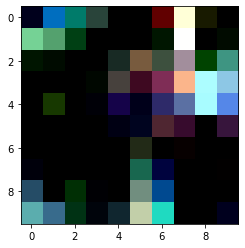

In [77]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

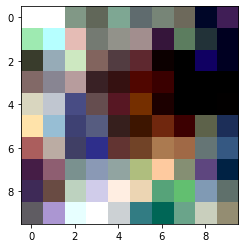

In [74]:
plt.imshow(Norma_Xpercentile(stack[5,:,:,]))

In [83]:
os.removedirs('/home/jgovoort/patch')

In [84]:
os.mkdir('./patch')

In [85]:
os.path.join('home','jgovoort','patch') 

'home/jgovoort/patch'

In [99]:
path = '/home/jgovoort/Images/Sentinel1.jpeg'
if os.path.splitext(path)[1] != '.tiff' or os.path.splitext(path)[1] != '.tif':
    sys.exit("NOT ALLOWED")

SystemExit: NOT ALLOWED

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [102]:
row = 'uygduhd,ddssdds,dsdsdsdsd,sddsszeez,dsdsd'
'|'.join(row.split(','))

'uygduhd|ddssdds|dsdsdsdsd|sddsszeez|dsdsd'